In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Input, Activation, concatenate
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical

In [2]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-06-11 13:33:53--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-11 13:33:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2024-06-11 13:36:32 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [3]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
df = pd.read_csv('/content/spam.csv')

In [5]:
sentences = df['Message'].tolist()
labels = df['Category'].tolist()

In [6]:
train_size = int(len(sentences) * 0.9)

In [7]:
training_sentences = sentences[0:train_size]
testing_sentences = sentences[train_size:]
training_labels = labels[0:train_size]
testing_labels = labels[train_size:]

In [8]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [9]:
tk = Tokenizer(char_level=True, oov_token='UNK')
tk.fit_on_texts(training_sentences)

alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

tk.word_index = char_dict.copy()
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

train_sequences = tk.texts_to_sequences(training_sentences)
test_texts = tk.texts_to_sequences(testing_sentences)

train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
test_data = pad_sequences(test_texts, maxlen=1014, padding='post')

train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

train_classes = train_data[0]
train_class_list = [x - 1 for x in train_classes]

test_classes = test_data[0]
test_class_list = [x - 1 for x in test_classes]

train_classes = to_categorical(train_class_list)
test_classes = to_categorical(test_class_list)

input_size = 1014
vocab_size = len(tk.word_index)
embedding_size = 69
conv_layers = [[256, 7, 3],
               [256, 7, 3],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, 3]]

fully_connected_layers = [1024, 1024]
dropout_p = 0.5

embedding_weights = []
embedding_weights.append(np.zeros(vocab_size))

for char, i in tk.word_index.items():
    onehot = np.zeros(vocab_size)
    onehot[i - 1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)

emb_layer = Embedding(vocab_size + 1,
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

inputs = Input(shape=(input_size), name='input', dtype='int64')
x = emb_layer(inputs)

for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x)
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)

x = Flatten()(x)

for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_p)(x)

x = Dense(1, activation='relu')(x)
x = Model(inputs = inputs, outputs = x)

In [10]:
embedding_index = {}
embedding_dim = 100
f = open(os.path.join('/content/glove.6B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
X_train = pad_sequences(sequences, maxlen = 100)
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
X_test = pad_sequences(test_sequences, maxlen = 100)

In [12]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

In [14]:
input_y = Input(shape=(100), name='input_2')
y = embedding_layer(input_y)
y = Bidirectional(LSTM(units=20, dropout=0.2, recurrent_dropout=0.25))(y)
# y = Dense(1, activation = 'sigmoid')(y)
y = Model(inputs = input_y, outputs = y)

In [15]:
combined = concatenate([x.output, y.output])

In [16]:
z = Dense(2, activation = 'relu')(combined)
z = Dense(1, activation = 'sigmoid')(z)

In [17]:
model = Model(inputs = [x.input, y.input], outputs = z)

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary ()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 1014)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1014, 69)             4830      ['input[0][0]']               
                                                                                                  
 conv1d (Conv1D)             (None, 1008, 256)            123904    ['embedding[0][0]']           
                                                                                                  
 activation (Activation)     (None, 1008, 256)            0         ['conv1d[0][0]']              
                                                                                            

In [20]:
history=model.fit(x=[train_data, X_train], y=training_labels_final,\
                  epochs=5, validation_data=([test_data, X_test], testing_labels_final))

Epoch 1/5
157/157 [==============================] - 163s 892ms/step - loss: 0.4160 - accuracy: 0.8550 - val_loss: 0.2290 - val_accuracy: 0.8710
Epoch 2/5
157/157 [==============================] - 122s 780ms/step - loss: 0.1963 - accuracy: 0.8654 - val_loss: 0.1539 - val_accuracy: 0.8710
Epoch 3/5
157/157 [==============================] - 130s 831ms/step - loss: 0.1549 - accuracy: 0.9079 - val_loss: 0.1377 - val_accuracy: 0.9713
Epoch 4/5
157/157 [==============================] - 123s 786ms/step - loss: 0.1399 - accuracy: 0.9679 - val_loss: 0.1216 - val_accuracy: 0.9749
Epoch 5/5
157/157 [==============================] - 131s 834ms/step - loss: 0.1292 - accuracy: 0.9749 - val_loss: 0.1132 - val_accuracy: 0.9767


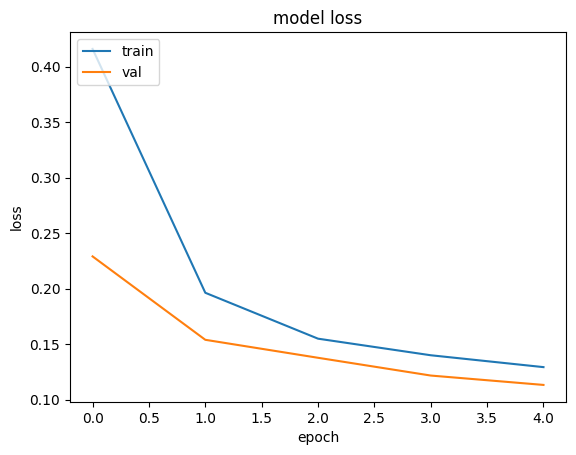

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()